## Script to parse behavioral data from pickle files

The purpose of this notebook is to parse the behavioral data in the appropriate pickle files into a format that is easily usable for analysis and plotting.

The pickle files for each animal contain dictionaries where the keys are session names and the values are lists of trials where every trial is a dictionary of this form:

```            trial = {
                'trial_num': 347,
                'stim_presentation_time': 1134567, # in microseconds
                'behavior_outcome_time': 1734567, # in microseconds
                'reaction_time': 600000, # in microseconds
                'behavior_outcome': 'success', # can be 'success', 'failure' or 'ignore'
                'BlobIdentityIdx': 1, # can be 1 or 2
                'response_location': 'left', # can be 'left' or 'right' corresponding to lickport
                'answer_location': 'left' # can be 'left' or 'right' (lickport location that is correct on trial)
            }
```

Continue below for how these data will be transformed. Make sure to run these cells in order.

### Dependencies

In [1]:
# must be running Python 3 for PsyTrack to work!

from __future__ import division
import os
import math
import random
import scipy
from pylab import figure
import scipy.stats as stats
from scipy.ndimage import gaussian_filter
import numpy as np
import pickle
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
import psytrack as psy
%matplotlib inline

### Functions  and parameters needed to parse the pickle files

##### Parameters for running parsing

In [2]:
bootstrap_iterations = 100 # choose number of bootstrap iterations for calculating performance error
wiggle_session_indices = False # for binning data over normalized session time. if True adds random noise to session_indices so they don't completely overlap if same number of sessions, etc

##### Location of files

In [3]:
# filepaths of data to analyze

# transparent/dim
filepath_transparency_psytrack = './transparency_psytrack/pickle_files_by_session/'

# fullcross baseline before transparent/dim
filepath_reg_before_transparency_psytrack = './fullcross_before_transparency_psytrack/pickle_files_by_session/'

##### Defining functions

**Logic:**

Function ```open_pickle_files_and_analyze()``` takes in the ```filepath``` as input, finds the pickle files, and then runs the function ```get_data```

Function ```get_data()``` takes in ```animal_name``` and ```trials_grouped_by_session``` as input, and then outputs a dictionary with the parsed data of the following form:

``` data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'iti_by_trial': iti_by_trial,
    'response_location_by_trial': response_location_by_trial,
    'answer_location_by_trial': answer_location_by_trial,
    'stim_id_by_trial': stim_id_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'response_location_by_session': response_location_by_session,
    'answer_location_by_session': answer_location_by_session,
    'stim_id_by_session': stim_id_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'bootstrap_error_by_session': bootstrap_error_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_error_by_session': rt_success_error_by_session,
    'rt_failure_error_by_session': rt_failure_error_by_session,
    'rt_error_by_session': rt_error_by_session,
    'norm_session_indices': norm_session_indices
    } 
```

where:

- ***animal_name*** : animal name  
- **rt_by_trial** : list of individual trial reaction times across all sessions in pickle file
- **outcome_by_trial** : list of individual trial outcomes ('success', 'failure') across all sessions in pickle file
- **iti_by_trial** : list of individual trial intertrial intervals across all sessions in pickle file
- **response_location_by_trial**: list of 'left' or 'right' for lickport response 
- **answer_location_by_trial**: list of 'left' or 'right' for correct lickport on that trial 
- **stim_id_by_trial**: list of 0 or 1 for BlobIdentityIdx (which stimulus was shown) for every trial

- **beh_outcome_by_session** : dict where key = session, val = of individual trial outcomes ('success', 'failure')
- **rt_by_session** : dict where key = session, val = individual trial reaction times
- **rt_success_by_session** : dict where key = session, val = individual success trial reaction times
- **rt_failure_by_session** : dict where key = session, val = individual failure trial reaction times
- **iti_by_session** : dict where key = session, val = individual trial intertrial intervals
- **response_location_by_session**: dict where key = session, val = list of 'left' or 'right' for lickport response 
- **answer_location_by_session**: dict where key = session, val = list of 'left' or 'right' for correct lickport on that trial 
- **stim_id_by_session**: dict where key = session, val = list of 0 or 1 for BlobIdentityIdx (which stimulus was shown) for every trial

- **pct_correct_by_session** : dict where key = session, val = accuracy for that session
- **bootstrap_error_by_session** : dict where key = session, val = bootstrapped accuracy error for that session
    
- **avg_rt_success_by_session** : dict where key = session, val = avg RT for success trials in that session
- **avg_rt_failure_by_session** : dict where key = session, val = avg RT for failure trials in that session
- **rt_success_error_by_session** : dict where key = session, val = bootstrapped RT error for success trials in that session
- **rt_failure_error_by_session** : dict where key = session, val = bootstrapped RT error for success trials in that session

- **norm_session_indices** : list of indices for sessions normalized from 0 to 1 (if animal takes 10 sessions to learn, then list contains [0.1, 0.2, 0.3,...,1.0]

the user can then use this data as she/he/they pleases. Some examples in the cells below.

In [4]:
def open_pickle_files_and_analyze(filepath):
    # get list of pickle file filenames in filepath
    dirs_list = [each for each in os.walk(filepath)]
    dirs_list = dirs_list[0][2] # capture only the pickle file filenames
    dirs_list = [i for i in dirs_list if i.startswith('.') == False] # remove hidden files

    # initiate dictionaries that will hold data
    results_by_session = {} # dictionary where keys will be animals, and values will be data
    sessions_by_animal = {} # dictionary where keys will be animals, and values will be session names

    # load the pickle files in the dirs_list one by one
    for filename in dirs_list:
        with open(filepath + filename, 'rb') as handle:
            data = pickle.load(handle)
        
        animal = list(data.keys())[0]# get animal name

        # notify the user of the sessions that are read
        print(' ')
        print('Read data from', animal, 'for...')
        print('sessions:')
        for session in sorted(data[animal].keys()):
            print(session)

        # lump sessions from all phases into one dictionary
        trials_grouped_by_session = data[animal]
        
        # then analyze
        result_by_session = get_data(animal, trials_grouped_by_session) # analyze one animal at a time
        # store data in dictionaries
        results_by_session[animal] = result_by_session # add to results_by_session dictionary
        sessions_by_animal[animal] = result_by_session['avg_rt_success_by_session'].keys() # add sessions to sessions_by_animal dictionary

    return results_by_session

def get_data(animal_name, trials_grouped_by_session):
    
    # ~~~~~~~~~ Capture trial data ~~~~~~~~~
    
    data_by_trial = trial_data(trials_grouped_by_session)
    rt_by_trial = data_by_trial['rt_by_trial']
    outcome_by_trial = data_by_trial['outcome_by_trial']
    iti_by_trial = data_by_trial['iti_by_trial']
    response_location_by_trial = data_by_trial['response_location_by_trial']
    answer_location_by_trial = data_by_trial['answer_location_by_trial']
    stim_id_by_trial = data_by_trial['stim_id_by_trial']
    
    # ~~~~~~~~~ Capture session data ~~~~~~~~~
    
    data_by_session = session_data(trials_grouped_by_session)
    beh_outcome_by_session = data_by_session['beh_outcome_by_session']
    rt_by_session = data_by_session['rt_by_session']
    rt_success_by_session = data_by_session['rt_success_by_session']
    rt_failure_by_session = data_by_session['rt_failure_by_session']
    iti_by_session = data_by_session['iti_by_session']
    response_location_by_session = data_by_session['response_location_by_session']
    answer_location_by_session = data_by_session['answer_location_by_session']
    stim_id_by_session = data_by_session['stim_id_by_session']
    
    # ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

    avg_rt_success_by_session = average_data_rt(rt_success_by_session)
    avg_rt_failure_by_session = average_data_rt(rt_failure_by_session)
    avg_rt_by_session = average_data_rt(rt_by_session)

    rt_success_error_by_session = bootstrap_error_rt(rt_success_by_session, bootstrap_iterations)
    rt_failure_error_by_session = bootstrap_error_rt(rt_failure_by_session, bootstrap_iterations)
    rt_error_by_session = bootstrap_error_rt(rt_by_session, bootstrap_iterations)
    
    # ~~~~~~~~~~ Performance analysis ~~~~~~~~~~
    
    pct_correct_by_session = pct_correct(beh_outcome_by_session)
    
    bootstrap_error_by_session = bootstrap_error_perf(beh_outcome_by_session, bootstrap_iterations)
    
    # ~~~~~~~~~~~~ Session indices ~~~~~~~~~~~~

    norm_session_indices = [(x+1)/len(pct_correct_by_session) for x in range(len(pct_correct_by_session))]
    norm_session_indices = [(x+1)/len(avg_rt_success_by_session) for x in range(len(avg_rt_success_by_session))]

    data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'iti_by_trial': iti_by_trial,
    'response_location_by_trial': response_location_by_trial,
    'answer_location_by_trial': answer_location_by_trial,
    'stim_id_by_trial': stim_id_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'response_location_by_session': response_location_by_session,
    'answer_location_by_session': answer_location_by_session,
    'stim_id_by_session': stim_id_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'bootstrap_error_by_session': bootstrap_error_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_error_by_session': rt_success_error_by_session,
    'rt_failure_error_by_session': rt_failure_error_by_session,
    'rt_error_by_session': rt_error_by_session,
    'norm_session_indices': norm_session_indices
    }

    return data

# ~~~~~~~~~ Capture trial data ~~~~~~~~~

# get trial data in big lists across all sessions
def trial_data(trials_grouped_by_session):
    # initialize lists for trial data across all sessions
    rt = []
    outcome = []
    iti = []
    resp_loc = []
    answ_loc = []
    stim_id = []

    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.keys()):
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            
            # only take into account the success or failure trials
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']:
               
                # append reaction time 
                rt.append(trials[trial_index]['reaction_time'])
                # append behavior outcome
                outcome.append(trials[trial_index]['behavior_outcome'])
                # append response location and correct answer location
                resp_loc.append(trials[trial_index]['response_location'])
                answ_loc.append(trials[trial_index]['answer_location'])
                # append stimulus identity
                stim_id.append(trials[trial_index]['BlobIdentityIdx'])
                
                
                # intertrial interval analysis
                if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                    iti.append(iti_for_first_trial)
                elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                    next_stim_time = trials[trial_index]['stim_presentation_time']
                    response_time = trials[trial_index - 1]['behavior_outcome_time'] # previous trial behavior_outcome_time
                    inter_trial_interval = (next_stim_time - response_time)*0.001
                    iti.append(inter_trial_interval)
                    
            # ignore the 'ignore' trials for now
            elif trials[trial_index]['behavior_outcome'] == 'ignore':
                pass 
          
    data_by_trial = {
    'rt_by_trial': rt,
    'outcome_by_trial': outcome,
    'iti_by_trial': iti,
    'response_location_by_trial': resp_loc,
    'answer_location_by_trial': answ_loc,
    'stim_id_by_trial': stim_id
    }
    return data_by_trial

# ~~~~~~~~~ Capture session data ~~~~~~~~~

def session_data(trials_grouped_by_session):
    # initialize dictionaries for trial data by sessions
    beh_outcome_by_session = {}
    rt_by_session = {}
    rt_success_by_session = {}
    rt_failure_by_session = {}
    iti_by_session = {}
    response_location_by_session = {}
    answer_location_by_session = {}
    stim_id_by_session = {}
    
    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.keys()):
        session_rt_success = []
        session_rt_failure = []
        session_rt = []
        session_behavior_outcome = []
        session_iti = []
        session_resp_loc = []
        session_answ_loc = []
        session_stim_id = []
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            # behavior outcome and rt analysis
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']: # WITHOUT IGNORES
                session_rt.append(trials[trial_index]['reaction_time'])
                session_behavior_outcome.append(trials[trial_index]['behavior_outcome'])
                # response location and correct answer location
                session_resp_loc.append(trials[trial_index]['response_location'])
                session_answ_loc.append(trials[trial_index]['answer_location'])
                # append stimulus identity
                session_stim_id.append(trials[trial_index]['BlobIdentityIdx'])
                
                if trials[trial_index]['behavior_outcome'] == 'success':
                    session_rt_success.append(trials[trial_index]['reaction_time'])
                elif trials[trial_index]['behavior_outcome'] == 'failure':
                    session_rt_failure.append(trials[trial_index]['reaction_time'])
                    
            # intertrial interval analysis
            if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                session_iti.append(iti_for_first_trial)
            elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                next_stim_time = trials[trial_index]['stim_presentation_time']
                response_time = trials[trial_index - 1]['behavior_outcome_time'] # previous trial behavior_outcome_time
                inter_trial_interval = (next_stim_time - response_time)*0.001
                session_iti.append(inter_trial_interval)

        beh_outcome_by_session[session] = session_behavior_outcome
        rt_by_session[session] = session_rt
        rt_success_by_session[session] = session_rt_success
        rt_failure_by_session[session] = session_rt_failure
        iti_by_session[session] = session_iti
        response_location_by_session[session] = session_resp_loc
        answer_location_by_session[session] = session_answ_loc
        stim_id_by_session[session] = session_stim_id
        
    data_by_session = {
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'response_location_by_session': response_location_by_session,
    'answer_location_by_session': answer_location_by_session,
    'stim_id_by_session': stim_id_by_session
    }
    
    return data_by_session

# ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

def average_data_rt(data_by_session):
    avg_by_session = {}
    for session in sorted(data_by_session.keys()):
        data = data_by_session[session]
        # if the session was empty, insert a NaN
        if len(data) > 0:
            avg = np.mean(data)
        elif len(data) == 0:
            avg = float('nan')
        avg_by_session[session] = avg
    return avg_by_session


def bootstrap_error_rt(data_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(data_by_session.keys()):
        data = data_by_session[session]

        # print 'data'
        # print data
        # print ' '

        total_trials = len(data)
        
        # print 'len(data)'
        # print len(data)
        # print ' '
        if total_trials > 0:
            list_of_avg = []
            for i in range(bootstrap_iterations):
                r = np.random.choice(data, total_trials)
                avg = np.mean(r)
                list_of_avg.append(avg)
            mean_error = np.std(list_of_avg)
            bootstrap_error_by_session[session] = mean_error
        else:
            bootstrap_error_by_session[session] = float('nan')
    return bootstrap_error_by_session

# ~~~~~~~~~~ Performance analysis ~~~~~~~~~~

def pct_correct(beh_out_by_session):
    pct_correct_by_session = {}
    for session in sorted(beh_out_by_session.keys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        counter = Counter(outcomes)
        if total_trials > 0:
            pct = counter['success'] / total_trials
        elif total_trials == 0:
            pct = float('nan')
        pct_correct_by_session[session] = pct
    return pct_correct_by_session


def bootstrap_error_perf(beh_out_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(beh_out_by_session.keys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        list_of_pct = []
        if total_trials > 0:
            for i in range(bootstrap_iterations):
                r = np.random.choice(outcomes, total_trials)
                counter = Counter(r)
                pct = counter['success'] / total_trials
                list_of_pct.append(pct)
            mean_error = np.std(list_of_pct)
        elif total_trials == 0:
            mean_error = float('nan')
        bootstrap_error_by_session[session] = mean_error
    return bootstrap_error_by_session

In [5]:
def prep_data_for_psytrack(results_dictionary):
    
    psytrack_dict = {}
    for animal in results_dictionary.keys():
        psytrack_dict[animal] = pack_dict_for_psytrack(results_dictionary, animal)
    return psytrack_dict

def pack_dict_for_psytrack(results_dictionary, animal):
    
    data_dict = {
        'name': None, # subject name
        'y': None, # response locations
        'answer': None, # correct answer locations
        'correct': None, # outcome of trial (0 if incorrect, 1 if correct)
        'inputs': {
            'previous_y': None, # previous trial response location
            'previous_answer': None, # previous trial correct answer location
            'stim': None, # -1 for stim_A, +1 for stim_B
            'stim_A': None, # +1 if stim_A present 0 otherwise
            'stim_B': None} # +1 if stim_B present, 0 otherwise
        } 
        
    resp_loc = results_dictionary[animal]['response_location_by_trial']
    y = [1 if i =='left' else 2 for i in resp_loc] # convert 'left' & 'right' to 1 and 2

    answ_loc = results_dictionary[animal]['answer_location_by_trial']
#     answer = [1 if i =='left' else 2 for i in answ_loc] # convert 'left' & 'right' to 1 and 2
    answer = [-1 if i =='left' else 1 for i in answ_loc] # convert 'left' & 'right' to 1 and 2

    outcome = results_dictionary[animal]['outcome_by_trial']
    correct = [0 if i =='failure' else 1 for i in outcome]
    
    stim_id = results_dictionary[animal]['stim_id_by_trial']
    stim = [-1 if i == 0 else 1 for i in stim_id] # -1 if BlobIdentityIdx = 0, +1 if BlobIdentityIdx = 1
    stim_A = [1 if i == 0 else 0 for i in stim_id] # true if stim_A (BlobIdentityIdx = 0)
    stim_B = stim_id # true if stim_B (BlobIdentityIdx = 1)
    stim = np.reshape(stim, (len(stim_A), 1)) # convert to N x 1 matrix (array won't work for PsyTrack!)
    stim_A = np.reshape(stim_A, (len(stim_A), 1)) # convert to N x 1 matrix (array won't work for PsyTrack!)
    stim_B = np.reshape(stim_B, (len(stim_B), 1)) # convert to N x 1 matrix (array won't work for PsyTrack!)

    # must save y and answer first before using pop() fxn below
    data_dict['name'] = animal
    data_dict['y'] = np.array(y)
    data_dict['answer'] = np.array(answer)
    data_dict['correct'] = np.array(correct)
    data_dict['inputs']['stim'] = np.array(stim)
    data_dict['inputs']['stim_A'] = np.array(stim_A)
    data_dict['inputs']['stim_B'] = np.array(stim_B)

    y.pop(-1) # remove last element of y
    ynew = [-1 if i==1 else 1 for i in y]
    previous_y = np.array([1] + ynew) # 1 plus new y list without last element
    previous_y = np.reshape(previous_y, (len(previous_y), 1)) # convert to N x 1 matrix (array won't work for PsyTrack!)

    answer.pop(-1)
    previous_answer = np.array([1] + answer)
    previous_answer = np.reshape(previous_answer, (len(previous_answer), 1)) # convert to N x 1 matrix (array won't work for PsyTrack!)

    data_dict['inputs']['previous_y'] = previous_y
    data_dict['inputs']['previous_answer'] = previous_answer
    
    return data_dict

def fit_data_with_psytrack(psytrack_dict, weights=None, hyper=None, optList=None):
        
    psytrack_output = {}
    for animal in psytrack_dict.keys():
        psytrack_output[animal] = fit_individuals_with_psytrack(psytrack_dict, animal, weights, hyper, optList)
        print('finished fitting', animal, '...')
    print('done!')
    return psytrack_output

def fit_individuals_with_psytrack(psytrack_dict, animal, weights, hyper, optList):

    # default values
    if weights is None:
        weights = {'bias': 1,
                   'previous_y':1,
                   'previous_answer':1,
                   'stim': 1} #,
                   #'stim_A': 1,
                   #'stim_B': 1} 
    K = np.sum([weights[i] for i in weights.keys()])
    if hyper is None:
        hyper= {'sigInit': 2**4.,      # Set to a single, large value for all weights. Will not be optimized further.
                'sigma': [2**-4.]*K,   # Each weight will have it's own sigma optimized, but all are initialized the same
                'sigDay': None}        # Indicates that session boundaries will be ignored in the optimization
    if optList is None:
        optList = ['sigma']

    model_dict = {
        'hyp': None,
        'evd': None,
        'wMode': None,
        'hess_info': None}
    
    # fit the model for individual animal
    D = psytrack_dict[animal] # define data for model
    hyp, evd, wMode, hess_info = psy.hyperOpt(D, hyper, weights, optList)

    # save output into output dictionary by animal name
    model_dict['hyp'] = hyp
    model_dict['evd'] = evd
    model_dict['wMode'] = wMode
    model_dict['hess_info'] = hess_info
    
    return model_dict

### Run the parsing

Below, the ```results``` dictionary will hold all the results for all the animals present in the pickle files in ```filepath```.

Run the cell below to populate ```results```.

In [6]:
results_by_session_baseline_psytrack = open_pickle_files_and_analyze(filepath_reg_before_transparency_psytrack)

 
Read data from AK10 for...
sessions:
AK10_180620.mwk
AK10_180621.mwk
AK10_180622.mwk
AK10_180623.mwk
AK10_180624.mwk
 
Read data from AK11 for...
sessions:
AK11_180620.mwk
AK11_180621.mwk
AK11_180622.mwk
AK11_180623.mwk
AK11_180624.mwk
 
Read data from AK12 for...
sessions:
AK12_180620.mwk
AK12_180621.mwk
AK12_180622.mwk
AK12_180623.mwk
AK12_180624.mwk
 
Read data from AK1 for...
sessions:
AK1_180620.mwk
AK1_180622.mwk
AK1_180623.mwk
AK1_180624.mwk
 
Read data from AK2 for...
sessions:
AK2_180620.mwk
AK2_180621.mwk
AK2_180622.mwk
AK2_180623.mwk
AK2_180624.mwk
 
Read data from AK3 for...
sessions:
AK3_180620.mwk
AK3_180621.mwk
AK3_180622.mwk
AK3_180623.mwk
AK3_180624.mwk
 
Read data from AK5 for...
sessions:
AK5_180620.mwk
AK5_180621.mwk
AK5_180622.mwk
AK5_180623.mwk
AK5_180624.mwk
 
Read data from AK6 for...
sessions:
AK6_180620.mwk
AK6_180621.mwk
AK6_180622.mwk
AK6_180623.mwk
AK6_180624.mwk
 
Read data from AK7 for...
sessions:
AK7_180621.mwk
AK7_180622.mwk
AK7_180623.mwk
AK7_180624

In [7]:
results_by_session_transp_psytrack = open_pickle_files_and_analyze(filepath_transparency_psytrack)

 
Read data from AK10_transparent0.1 for...
sessions:
AK10_180625transparency0.1.mwk
AK10_180626transparency0.1.mwk
AK10_180627transparency0.1.mwk
AK10_180628transparency0.1.mwk
AK10_180629transparency0.1.mwk
AK10_180824transparency0.1.mwk
AK10_180825transparency0.1.mwk
AK10_180827transparency0.1.mwk
AK10_180828transparency0.1.mwk
AK10_180829transparency0.1.mwk
AK10_180830transparency0.1.mwk
 
Read data from AK11_transparent0.0 for...
sessions:
AK11_180625transparency0.0.mwk
AK11_180626transparency0.0.mwk
AK11_180627transparency0.0.mwk
AK11_180628transparency0.0.mwk
AK11_180629transparency0.0.mwk
AK11_180824transparency0.0.mwk
AK11_180825transparency0.0.mwk
AK11_180827transparency0.0.mwk
AK11_180828transparency0.0.mwk
AK11_180829transparency0.0.mwk
AK11_180830transparency0.0.mwk
 
Read data from AK12_transparent0.1 for...
sessions:
AK12_180625transparency0.1.mwk
AK12_180626transparency0.1.mwk
AK12_180627transparency0.1.mwk
AK12_180628transparency0.1.mwk
AK12_180629transparency0.1.mwk
A

### Plot bias

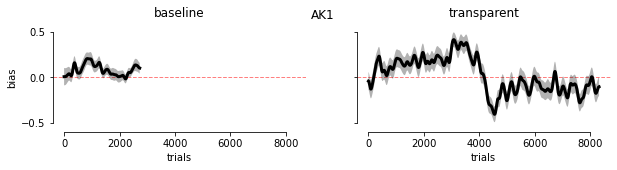

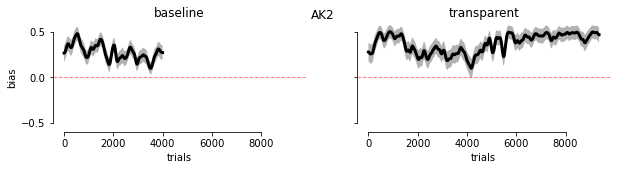

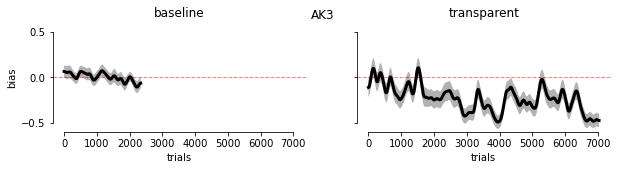

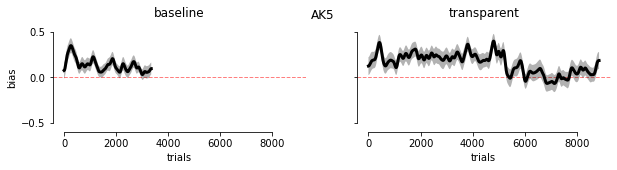

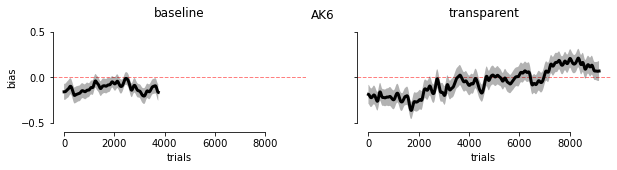

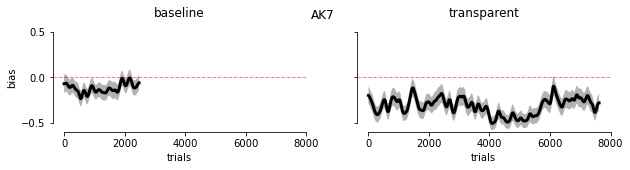

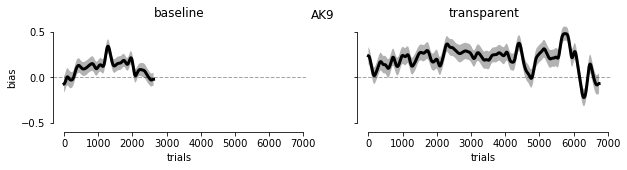

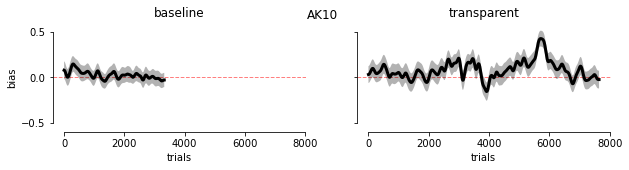

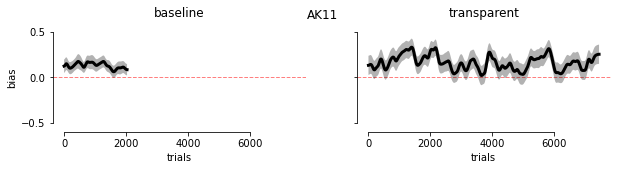

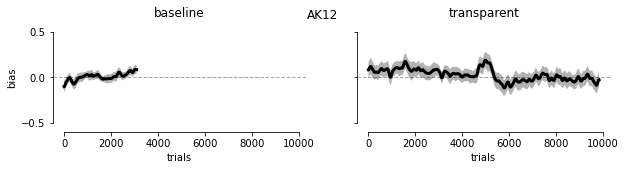

In [9]:
namepairs = {
    'AK1': 'AK1_transparent0.0',
    'AK2': 'AK2_transparent0.1',
    'AK3': 'AK3_transparent0.0',
    'AK5': 'AK5_transparent0.1',
    'AK6': 'AK6_transparent0.0',
    'AK7': 'AK7_transparent0.0',
    'AK9': 'AK9_transparent0.1',
    'AK10': 'AK10_transparent0.1',
    'AK11': 'AK11_transparent0.0',
    'AK12': 'AK12_transparent0.1'}

for name, name_transp in namepairs.items():
    
    resp = results_by_session_baseline_psytrack[name]['response_location_by_trial']
    resp = np.array([0. if i =='left' else 1. for i in resp])
    answ = results_by_session_baseline_psytrack[name]['answer_location_by_trial']
    answ = np.array([0. if i =='left' else 1. for i in answ])
    raw_bias_baseline = resp - answ

    resp = results_by_session_transp_psytrack[name_transp]['response_location_by_trial']
    resp = np.array([0. if i =='left' else 1. for i in resp])
    answ = results_by_session_transp_psytrack[name_transp]['answer_location_by_trial']
    answ = np.array([0. if i =='left' else 1. for i in answ])
    raw_bias_transp = resp - answ

    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,2), sharey=True, sharex=True)
    
    # Smoothing vector for errorbars
    sigma = 50
    QQQ = np.zeros(10001)
    QQQ[5000] = 1
    QQQ = gaussian_filter(QQQ, sigma)

    # Calculate smooth representation of empirical bias
    # raw_bias = choiceR - answerR
    smooth_bias = gaussian_filter(raw_bias_baseline, 50)
    ax1.axhline(0, linestyle='--', color = 'r', alpha = 0.5, lw=1)
    ax1.plot(smooth_bias, c='k', lw=3, zorder=4)
    ax1.set_yticks([-0.5,0,0.5])
    ax1.set_ylim([-0.6, 0.6])
    ax1.set_ylabel('bias')
    ax1.set_xlabel('trials')
    ax1.set_title('baseline')

    # Calculate errorbars on empirical performance
    bias_errorbars = np.sqrt(
        np.sum(QQQ**2) * gaussian_filter((raw_bias_baseline - smooth_bias)**2, sigma))
    ax1.fill_between(range(len(smooth_bias)),
                     smooth_bias - 1.96 * bias_errorbars,
                     smooth_bias + 1.96 * bias_errorbars,
                     facecolor='k', alpha=0.3, zorder=3)

    
    # Calculate smooth representation of empirical bias
    # raw_bias = choiceR - answerR
    smooth_bias = gaussian_filter(raw_bias_transp, 50)
    ax2.axhline(0, linestyle='--', color = 'r', alpha = 0.5, lw=1)
    ax2.plot(smooth_bias, c='k', lw=3, zorder=4)
    ax2.set_yticks([-0.5,0,0.5])
    ax2.set_ylim([-0.6, 0.6])
    ax2.set_xlabel('trials')
    ax2.set_title('transparent')

    # Calculate errorbars on empirical performance
    bias_errorbars = np.sqrt(
        np.sum(QQQ**2) * gaussian_filter((raw_bias_transp - smooth_bias)**2, sigma))
    plt.fill_between(range(len(smooth_bias)),
                     smooth_bias - 1.96 * bias_errorbars,
                     smooth_bias + 1.96 * bias_errorbars,
                     facecolor='k', alpha=0.3, zorder=3)
    
    sns.despine(trim=True)
    
    fig.suptitle(name)
    
    fig.savefig(f'{name}_baseline_transp_bias.pdf')

### PsyTrack model

In [8]:
# convert data to proper format for PsyTrack

psytrack_dict_base = prep_data_for_psytrack(results_by_session_baseline_psytrack)
psytrack_dict_transp = prep_data_for_psytrack(results_by_session_transp_psytrack)

In [11]:
# fit data with psytrack

w = {'bias': 1,'previous_y':1,'previous_answer':1,'stim': 1} 
psytrack_output_base = fit_data_with_psytrack(psytrack_dict_base, weights = w)

finished fitting AK10 ...
finished fitting AK11 ...
finished fitting AK12 ...
finished fitting AK1 ...
finished fitting AK2 ...
finished fitting AK3 ...
finished fitting AK5 ...
finished fitting AK6 ...
finished fitting AK7 ...
finished fitting AK9 ...
done!


In [15]:
# fit data with psytrack

w = {'bias': 1,'previous_y':1,'previous_answer':1,'stim': 1} 
psytrack_output_transp = fit_data_with_psytrack(psytrack_dict_transp, weights = w)

finished fitting AK10_transparent0.1 ...
finished fitting AK11_transparent0.0 ...
finished fitting AK12_transparent0.1 ...
finished fitting AK1_transparent0.0 ...
finished fitting AK2_transparent0.1 ...
finished fitting AK3_transparent0.0 ...
finished fitting AK5_transparent0.1 ...
finished fitting AK6_transparent0.0 ...
finished fitting AK7_transparent0.0 ...
finished fitting AK9_transparent0.1 ...
done!


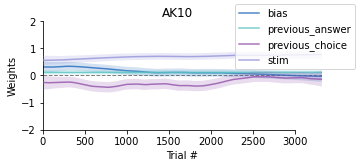

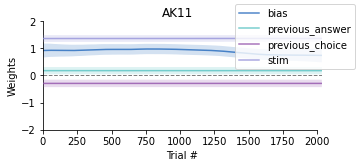

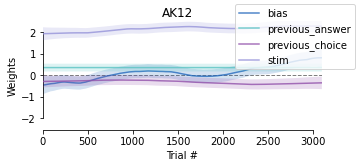

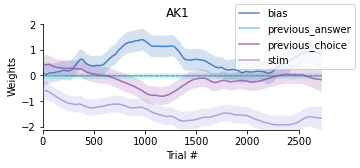

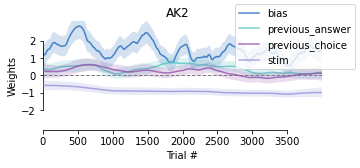

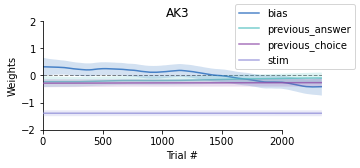

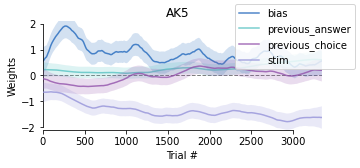

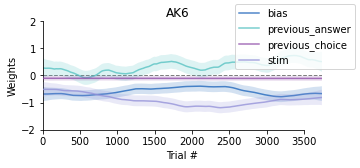

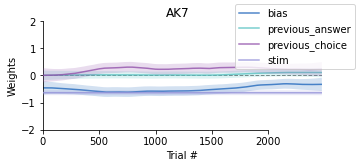

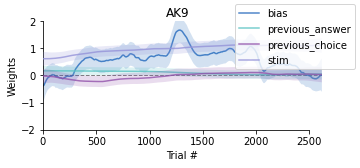

In [14]:
for animal in psytrack_output_base.keys():
    fig = psy.plot_weights(psytrack_output_base[animal]['wMode'][:,:], errorbar= psytrack_output_base[animal]['hess_info']['W_std'][:,:])
    fig.suptitle(animal)
    plt.yticks([-2,-1,0,1,2])
    sns.despine(trim=True)
    fig.savefig(f'{animal}_baseline_weights.pdf')
    fig.legend(('bias','previous_answer', 'previous_choice', 'stim'))
# fig.savefig(f'{animal}_baseline_weights.pdf')

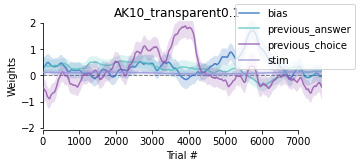

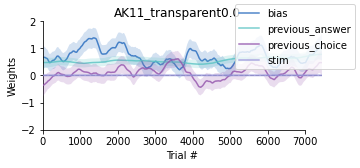

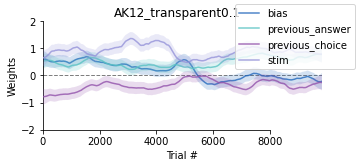

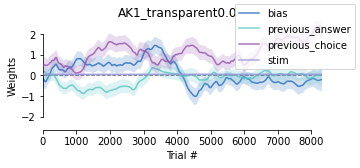

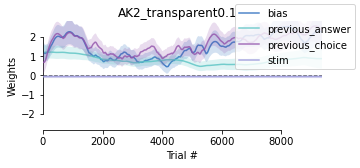

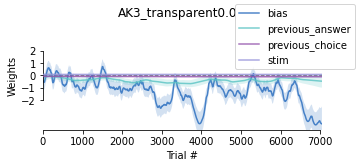

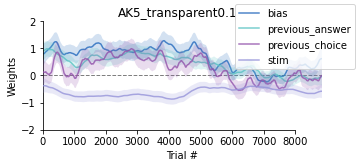

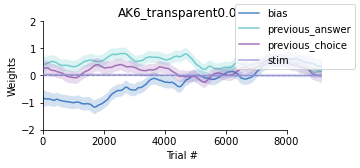

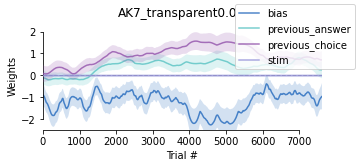

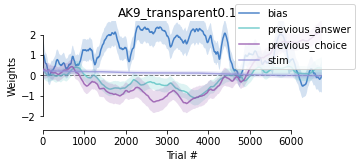

In [16]:
for animal in psytrack_output_transp.keys():
    fig = psy.plot_weights(psytrack_output_transp[animal]['wMode'][:,:], errorbar= psytrack_output_transp[animal]['hess_info']['W_std'][:,:])
    fig.suptitle(animal)
    plt.yticks([-2,-1,0,1,2])
    sns.despine(trim=True)
    fig.savefig(f'{animal}_transp_weights.pdf')
    fig.legend(('bias','previous_answer', 'previous_choice', 'stim'))
# fig.savefig(f'{animal}_transp_weights.pdf')

Text(0.5, 1.0, 'AK9')

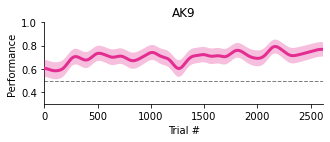

In [217]:
fig = psy.plot_performance(psytrack_dict_base['AK9'])
plt.title('AK9')

#### test psytrack model fit through cross-validation

In [137]:
# truncate data so it is divisible by folds

AK1_xval_data_base = psy.trim(psytrack_dict_base['AK1'], END=2500)
AK1_xval_data_transp = psy.trim(psytrack_dict_transp['AK1_transparent0.0'], END=8000)

AK2_xval_data_base = psy.trim(psytrack_dict_base['AK2'], END=3500)
AK2_xval_data_transp = psy.trim(psytrack_dict_transp['AK2_transparent0.1'], END=8000)

AK3_xval_data_base = psy.trim(psytrack_dict_base['AK3'], END=2000)
AK3_xval_data_transp = psy.trim(psytrack_dict_transp['AK3_transparent0.0'], END=7000)

AK6_xval_data_base = psy.trim(psytrack_dict_base['AK6'], END=3500)
AK6_xval_data_transp = psy.trim(psytrack_dict_transp['AK6_transparent0.0'], END=8000)

AK7_xval_data_base = psy.trim(psytrack_dict_base['AK7'], END=2000)
AK7_xval_data_transp = psy.trim(psytrack_dict_transp['AK7_transparent0.0'], END=7500)

AK9_xval_data_base = psy.trim(psytrack_dict_base['AK9'], END=2500)
AK9_xval_data_transp = psy.trim(psytrack_dict_transp['AK9_transparent0.1'], END=6000)

AK10_xval_data_base = psy.trim(psytrack_dict_base['AK10'], END=2500)
AK10_xval_data_transp = psy.trim(psytrack_dict_transp['AK10_transparent0.1'], END=7500)

AK11_xval_data_base = psy.trim(psytrack_dict_base['AK11'], END=2000)
AK11_xval_data_transp = psy.trim(psytrack_dict_transp['AK11_transparent0.0'], END=7400)

In [ ]:
# model params

weights = {'bias': 1,
           'previous_y':1,
           'previous_answer':1,
           'stim':1} 
K = np.sum([weights[i] for i in weights.keys()])

hyper= {'sigInit': 2**4.,      # Set to a single, large value for all weights. Will not be optimized further.
        'sigma': [2**-4.]*K,   # Each weight will have it's own sigma optimized, but all are initialized the same
        'sigDay': None}        # Indicates that session boundaries will be ignored in the optimization

optList = ['sigma']

In [134]:
AK1_base_xval_logli, AK1_base_xval_pL = psy.crossValidate(AK1_xval_data_base, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [135]:
AK1_transp_xval_logli, AK1_transp_xval_pL = psy.crossValidate(AK1_xval_data_transp, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [138]:
AK2_base_xval_logli, AK2_base_xval_pL = psy.crossValidate(AK2_xval_data_base, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [139]:
AK2_transp_xval_logli, AK2_transp_xval_pL = psy.crossValidate(AK2_xval_data_transp, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [140]:
AK3_base_xval_logli, AK3_base_xval_pL = psy.crossValidate(AK3_xval_data_base, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [141]:
AK3_transp_xval_logli, AK3_transp_xval_pL = psy.crossValidate(AK3_xval_data_transp, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [143]:
AK6_base_xval_logli, AK6_base_xval_pL = psy.crossValidate(AK6_xval_data_base, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [144]:
AK6_transp_xval_logli, AK6_transp_xval_pL = psy.crossValidate(AK6_xval_data_transp, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [145]:
AK7_base_xval_logli, AK7_base_xval_pL = psy.crossValidate(AK7_xval_data_base, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [146]:
AK7_transp_xval_logli, AK7_transp_xval_pL = psy.crossValidate(AK7_xval_data_transp, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [147]:
AK9_base_xval_logli, AK9_base_xval_pL = psy.crossValidate(AK9_xval_data_base, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [148]:
AK9_transp_xval_logli, AK9_transp_xval_pL = psy.crossValidate(AK9_xval_data_transp, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [106]:
AK10_base_xval_logli, AK10_base_xval_pL = psy.crossValidate(AK10_xval_data_base, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [118]:
AK10_transp_xval_logli, AK10_transp_xval_pL = psy.crossValidate(AK10_xval_data_transp, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [124]:
AK11_base_xval_logli, AK11_base_xval_pL = psy.crossValidate(AK11_xval_data_base, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

In [131]:
AK11_transp_xval_logli, AK11_transp_xval_pL = psy.crossValidate(AK11_xval_data_transp, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

negative log-likelihood -1578.2580350127214


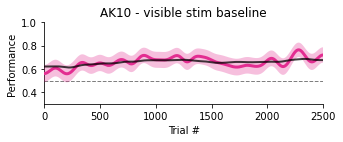

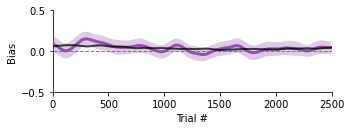

In [125]:
fig = psy.plot_performance(AK10_xval_data_base, xval_pL=AK10_base_xval_pL)
plt.title('AK10 - visible stim baseline')
fig = psy.plot_bias(AK10_xval_data_base, xval_pL=AK10_base_xval_pL)
print(f'negative log-likelihood {AK10_base_xval_logli}')

negative log-likelihood -4624.074532630963


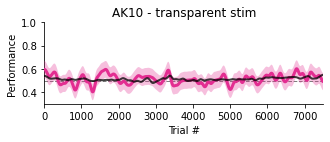

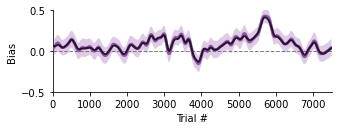

In [126]:
fig = psy.plot_performance(AK10_xval_data_transp, xval_pL=AK10_transp_xval_pL)
plt.title('AK10 - transparent stim')
fig = psy.plot_bias(AK10_xval_data_transp, xval_pL=AK10_transp_xval_pL)
print(f'negative log-likelihood {AK10_transp_xval_logli}')

negative log-likelihood -993.4459665106353


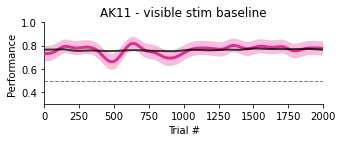

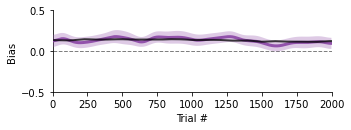

In [127]:
fig = psy.plot_performance(AK11_xval_data_base, xval_pL=AK11_base_xval_pL)
plt.title('AK11 - visible stim baseline')
fig = psy.plot_bias(AK11_xval_data_base, xval_pL=AK11_base_xval_pL)
print(f'negative log-likelihood {AK11_base_xval_logli}')

negative log-likelihood -4422.077527359363


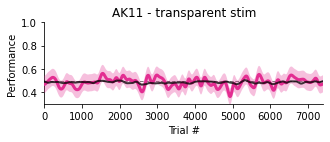

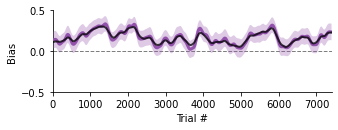

In [132]:
fig = psy.plot_performance(AK11_xval_data_transp, xval_pL=AK11_transp_xval_pL)
plt.title('AK11 - transparent stim')
fig = psy.plot_bias(AK11_xval_data_transp, xval_pL=AK11_transp_xval_pL)
print(f'negative log-likelihood {AK11_transp_xval_logli}')

#### Download sampleRatData to doublecheck coding scheme

In [186]:
sampleRatData = np.load('sampleRatData.npz', allow_pickle=True)['D'].item()

In [188]:
sampleRatData['inputs']

{'h': array([[-1.,  0.],
        [ 1., -1.],
        [ 1.,  1.],
        ...,
        [-1., -1.],
        [ 1., -1.],
        [-1.,  1.]]),
 'r': array([[-1.,  0.],
        [ 1., -1.],
        [ 1.,  1.],
        ...,
        [ 1.,  1.],
        [-1.,  1.],
        [ 1., -1.]]),
 'c': array([[ 1.,  0.],
        [ 1.,  1.],
        [ 1.,  1.],
        ...,
        [-1., -1.],
        [-1., -1.],
        [-1., -1.]]),
 's1': array([[-0.04184135, -0.04184135],
        [ 1.51889035, -0.04184135],
        [ 0.73846325,  1.51889035],
        ...,
        [ 1.59603762, -1.39664247],
        [ 0.84765711,  1.59603762],
        [ 0.10037948,  0.84765711]]),
 's2': array([[-0.82166801,  0.73846325],
        [ 0.73846325, -0.82166801],
        [-0.04184135,  0.73846325],
        ...,
        [ 0.84765711, -0.64849422],
        [ 1.59603762,  0.84765711],
        [ 0.84765711,  1.59603762]]),
 's_avg': array([[ 0.34831095,  0.        ],
        [-0.43175468,  0.34831095],
        [ 1.1286768 , -0.

#### bias simulation

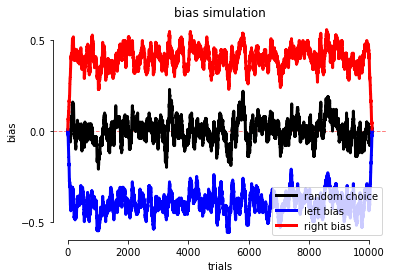

In [262]:
random_choice = np.random.choice([0,1],size=10000)
left_bias = np.random.choice([0,1],size=10000,p=[0.9,0.1])
right_bias = np.random.choice([0,1],size=10000,p=[0.1,0.9])
random_results = np.random.choice([0,1],size=10000)

bias_rc = random_choice - random_results
bias_lb = left_bias - random_results
bias_rb = right_bias - random_results

smooth_bias_rc = np.convolve(bias_rc,np.ones(100)/100)
smooth_bias_lb = np.convolve(bias_lb,np.ones(100)/100)
smooth_bias_rb = np.convolve(bias_rb,np.ones(100)/100)

plt.axhline(0, linestyle='--', color = 'r', alpha = 0.5, lw=1)
plt.plot(smooth_bias_rc, c='k', lw=3, label='random choice')
plt.plot(smooth_bias_lb, c='b',lw=3, label = 'left bias')
plt.plot(smooth_bias_rb, c='r',lw=3, label = 'right bias')
plt.yticks([-0.5,0,0.5])
plt.ylim([-0.6, 0.6])
plt.ylabel('bias')
plt.xlabel('trials')
plt.legend()
plt.title('bias simulation')

sns.despine(trim=True)

# fig.savefig(f'{name}_baseline_transp_bias.pdf')